In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import yfinance as yf
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import hvplot.pandas

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from fuzzywuzzy import process
import requests

In [3]:
company_request = 'Dow Jones'

In [4]:
def getCompany(text):
    r = requests.get('https://api.iextrading.com/1.0/ref-data/symbols')
    stockList = r.json()
    return process.extractOne(text, stockList)[0]

In [5]:
company = getCompany(company_request)

In [6]:
symbol = company['symbol']
company_name = company['name']
print(symbol)
print(company_name)

DJD
INVESCO DOW JONES INDUSTRIAL


In [7]:
data = yf.download(symbol, parse_dates=True, infer_datetime_format=True)

[*********************100%***********************]  1 of 1 downloaded


In [8]:
data['Daily Return'] = data['Close'].dropna().pct_change()

In [9]:
# Set short and long windows
short_window = 50
long_window = 100

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_close'] = data['Close'].ewm(halflife=short_window).mean()
data['slow_close'] = data['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
data['crossover_long'] = np.where(data['fast_close'] > data['slow_close'], 1.0, 0.0)
data['crossover_short'] = np.where(data['fast_close'] < data['slow_close'], -1.0, 0.0)
data['crossover_signal'] = data['crossover_long'] + data['crossover_short']

short_vol_window = 5
long_vol_window = 21

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_vol'] = data['Daily Return'].ewm(halflife=short_vol_window).std()
data['slow_vol'] = data['Daily Return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
data['vol_trend_long'] = np.where(data['fast_vol'] < data['slow_vol'], 1.0, 0.0)
data['vol_trend_short'] = np.where(data['fast_vol'] > data['slow_vol'], -1.0, 0.0) 
data['vol_trend_signal'] = data['vol_trend_long'] + data['vol_trend_short']

# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
data['bollinger_mid_band'] = data['Close'].rolling(window=bollinger_window).mean()
data['bollinger_std'] = data['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
data['bollinger_upper_band']  = data['bollinger_mid_band'] + (data['bollinger_std'] * 1)
data['bollinger_lower_band']  = data['bollinger_mid_band'] - (data['bollinger_std'] * 1)

# Calculate bollinger band trading signal
data['bollinger_long'] = np.where(data['Close'] < data['bollinger_lower_band'], 1.0, 0.0)
data['bollinger_short'] = np.where(data['Close'] > data['bollinger_upper_band'], -1.0, 0.0)
data['bollinger_signal'] = data['bollinger_long'] + data['bollinger_short']

# Set the short window and long windows
rolling_short_window = 50
rolling_long_window = 100

# Generate the short and long moving averages (50 and 100 days, respectively)
data["SMA50"] = data["Close"].rolling(window=short_window).mean()
data["SMA100"] = data["Close"].rolling(window=long_window).mean()

# Initialize the new `Signal` column
data["SMA_Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
data["SMA_Signal"][short_window:] = np.where(
    data["SMA50"][short_window:] < data["SMA100"][short_window:], 1.0, 0.0
)

data

data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-18,25.09,25.09,24.98,24.98,22.67,1700,NaN,24.980000,24.980000,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2015-12-21,24.99,25.05,24.90,25.00,22.69,9200,0.000801,24.990069,24.990035,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2015-12-22,25.10,25.30,25.10,25.30,22.96,2700,0.012000,25.094815,25.094073,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2015-12-23,25.30,25.30,25.30,25.30,22.96,0,0.000000,25.147183,25.146092,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2015-12-24,25.54,25.54,25.54,25.54,23.18,10400,0.009486,25.227939,25.225969,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0


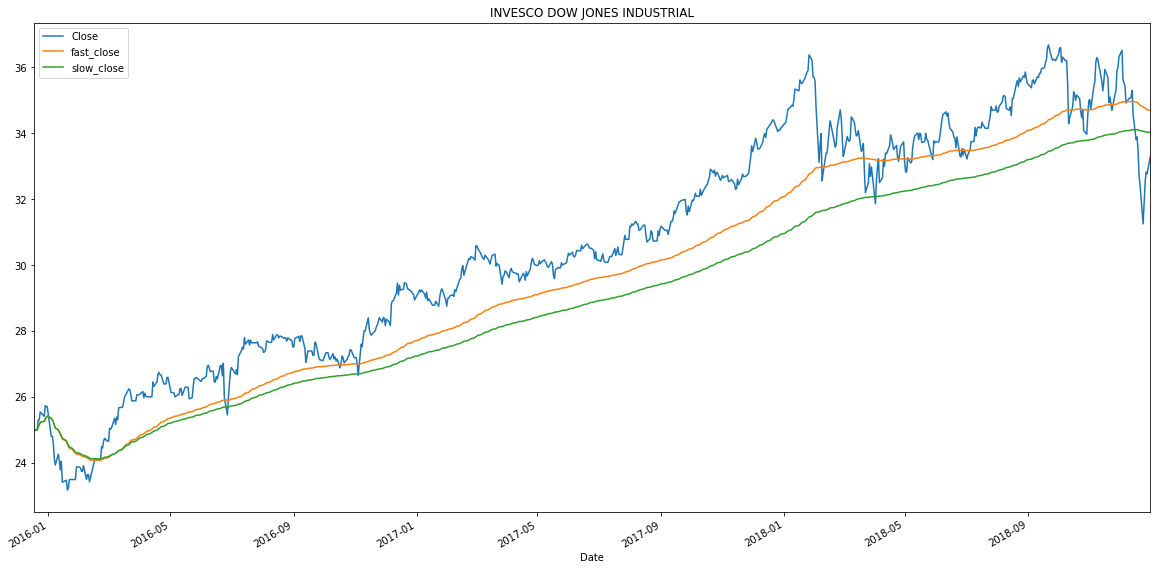

In [10]:
data.loc['2012-01-01':'2019-01-01'][['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10), title=company_name)

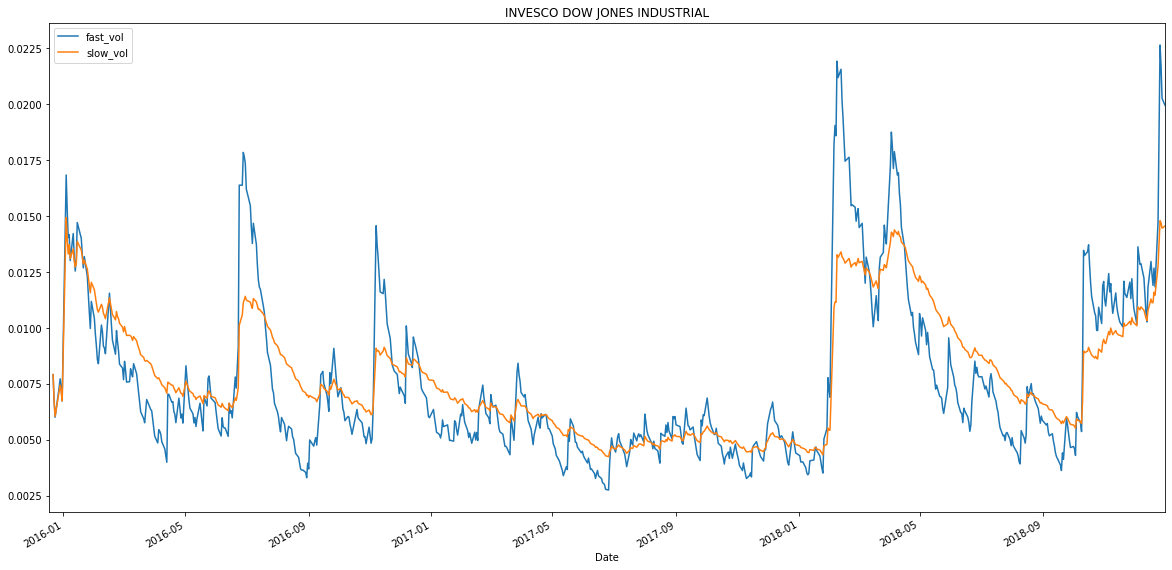

In [11]:
data.loc['2012-01-01':'2019-01-01'][['fast_vol', 'slow_vol']].plot(figsize=(20,10), title=company_name)

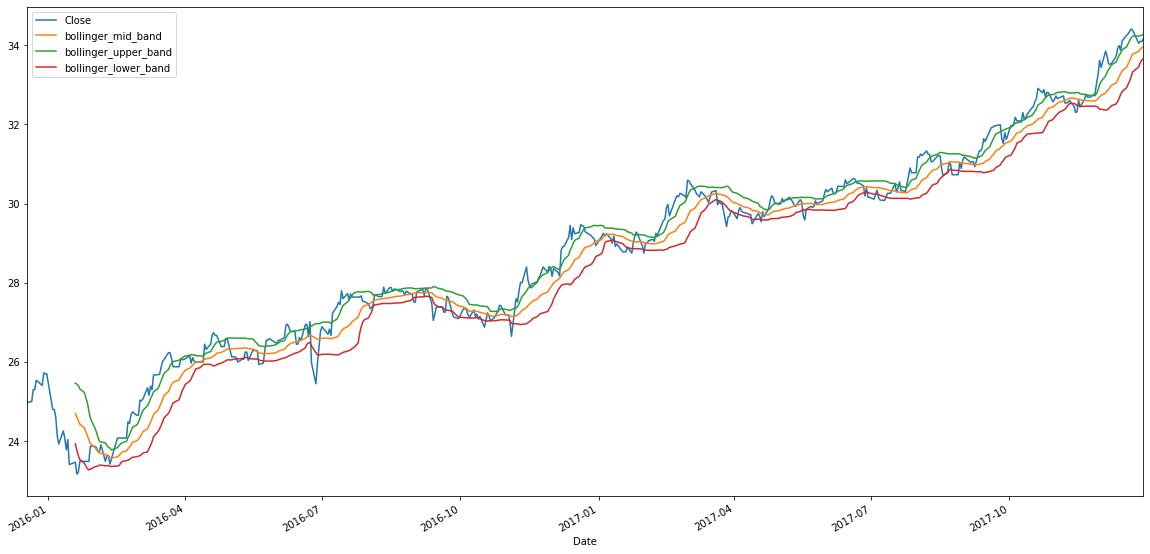

In [12]:
# Plot the Bollinger Bands for BTC/USD closing prices
data.loc['2015-01-01':'2018-01-01'][['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [13]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal', 'SMA_Signal']

# Filter by x-variable list
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2019-12-16,1.0,1.0,-1.0,0.0
2019-12-17,1.0,1.0,-1.0,0.0
2019-12-18,1.0,1.0,-1.0,0.0
2019-12-19,1.0,1.0,-1.0,0.0
2019-12-20,1.0,1.0,-1.0,0.0


In [14]:
data[x_var_list] = data[x_var_list].shift(1)
data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2019-12-16,1.0,1.0,-1.0,0.0
2019-12-17,1.0,1.0,-1.0,0.0
2019-12-18,1.0,1.0,-1.0,0.0
2019-12-19,1.0,1.0,-1.0,0.0
2019-12-20,1.0,1.0,-1.0,0.0


In [15]:
#signal_dataand replace positive/negative infinity values
data.dropna(subset=x_var_list, inplace=True)
data.dropna(subset=['Daily Return'], inplace=True)
data = data.replace([np.inf, -np.inf], np.nan)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-21,24.99,25.05,24.90,25.00,22.69,9200,0.000801,24.990069,24.990035,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2015-12-22,25.10,25.30,25.10,25.30,22.96,2700,0.012000,25.094815,25.094073,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2015-12-23,25.30,25.30,25.30,25.30,22.96,0,0.000000,25.147183,25.146092,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2015-12-24,25.54,25.54,25.54,25.54,23.18,10400,0.009486,25.227939,25.225969,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0
2015-12-28,25.41,25.41,25.41,25.41,23.06,500,-0.005090,25.259344,25.257175,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0


In [16]:
data['Positive Return'] = np.where(data['Daily Return'] > 0, 1.0, 0.0)
data

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-21,24.99,25.05,24.90,25.00,22.69,9200,0.000801,24.990069,24.990035,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0
2015-12-22,25.10,25.30,25.10,25.30,22.96,2700,0.012000,25.094815,25.094073,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0
2015-12-23,25.30,25.30,25.30,25.30,22.96,0,0.000000,25.147183,25.146092,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
2015-12-24,25.54,25.54,25.54,25.54,23.18,10400,0.009486,25.227939,25.225969,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0
2015-12-28,25.41,25.41,25.41,25.41,23.06,500,-0.005090,25.259344,25.257175,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-16,39.31,39.46,39.28,39.30,39.30,11300,0.006402,37.401679,36.556664,1.0,...,0.285419,39.028419,38.457581,0.0,-1.0,-1.0,38.0456,37.4391,0.0,1.0
2019-12-17,39.26,39.40,39.26,39.33,39.33,10400,0.000763,37.428227,36.575839,1.0,...,0.313646,39.088646,38.461354,0.0,-1.0,-1.0,38.1056,37.4524,0.0,1.0
2019-12-18,39.40,39.40,39.20,39.28,39.28,11000,-0.001271,37.453721,36.594536,1.0,...,0.332744,39.136244,38.470756,0.0,-1.0,-1.0,38.1754,37.4647,0.0,0.0


In [17]:
split = int(0.7 * len(data))

In [18]:
# Construct training start and end dates
training_start = data.index.min().strftime(format= '%Y-%m-%d')
training_end = data.index[split - 1].strftime(format= '%Y-%m-%d')

# Construct testing start and end dates
testing_start =  data.index[split].strftime(format= '%Y-%m-%d')
testing_end = data.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end} at 70% of data")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end} at latest data")

Training Start: 2015-12-21
Training End: 2018-10-08 at 70% of data
Testing Start: 2018-10-09
Testing End: 2019-12-20 at latest data


In [19]:
# Construct the x train and y train datasets
x_train = data[x_var_list][training_start:training_end]
y_train = data['Positive Return'][training_start:training_end]

x_train.tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2018-10-02,1.0,1.0,-1.0,0.0
2018-10-03,1.0,1.0,-1.0,0.0
2018-10-04,1.0,1.0,-1.0,0.0
2018-10-05,1.0,-1.0,0.0,0.0
2018-10-08,1.0,-1.0,0.0,0.0


In [20]:
# Construct the x test and y test datasets
x_test = data[x_var_list][testing_start:testing_end]
y_test = data['Positive Return'][testing_start:testing_end]

x_test.tail()

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2019-12-16,1.0,1.0,-1.0,0.0
2019-12-17,1.0,1.0,-1.0,0.0
2019-12-18,1.0,1.0,-1.0,0.0
2019-12-19,1.0,1.0,-1.0,0.0
2019-12-20,1.0,1.0,-1.0,0.0


# Start of Random Forest Testing 

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [22]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=5, max_depth=1000, random_state=None)
model.fit(x_train, y_train)

# Make a prediction of "y" values from the x test dataset
predictions = model.predict(x_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
result = y_test.to_frame()
result["Predicted Value"] = predictions
result

,Positive Return,Predicted Value
Date,,
2018-10-09,1.0,0.0
2018-10-10,0.0,0.0
2018-10-11,0.0,1.0
2018-10-12,1.0,1.0
2018-10-15,1.0,1.0
...,...,...
2019-12-16,1.0,1.0
2019-12-17,1.0,1.0
2019-12-18,0.0,1.0


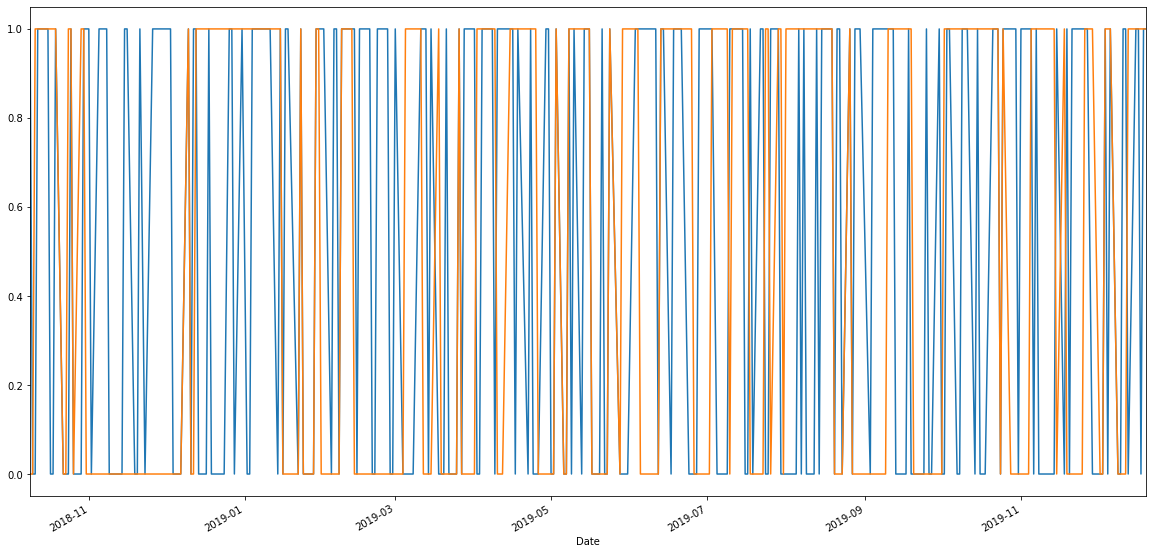

In [23]:
result['Positive Return'][testing_start:testing_end].plot(figsize=(20,10))
result['Predicted Value'][testing_start:testing_end].plot(figsize=(20,10))

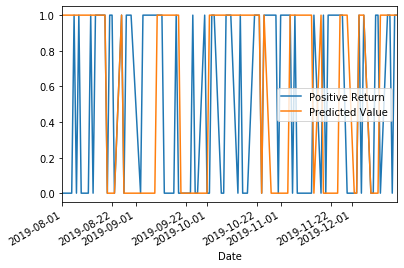

In [24]:
result[['Positive Return', 'Predicted Value']].tail(100).plot()

In [25]:
# Calculate the points in time at which a position should be taken, 1 or -1
data["Entry/Exit"] = result["Predicted Value"].diff()

In [26]:
x_test

,crossover_signal,vol_trend_signal,bollinger_signal,SMA_Signal
Date,,,,
2018-10-09,1.0,1.0,0.0,0.0
2018-10-10,1.0,1.0,0.0,0.0
2018-10-11,1.0,-1.0,1.0,0.0
2018-10-12,1.0,-1.0,1.0,0.0
2018-10-15,1.0,-1.0,1.0,0.0
...,...,...,...,...
2019-12-16,1.0,1.0,-1.0,0.0
2019-12-17,1.0,1.0,-1.0,0.0
2019-12-18,1.0,1.0,-1.0,0.0


In [27]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,SMA50,SMA100,SMA_Signal,Positive Return,Entry/Exit
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-16,39.31,39.46,39.28,39.30,39.30,11300,0.006402,37.401679,36.556664,1.0,...,39.028419,38.457581,0.0,-1.0,-1.0,38.0456,37.4391,0.0,1.0,0.0
2019-12-17,39.26,39.40,39.26,39.33,39.33,10400,0.000763,37.428227,36.575839,1.0,...,39.088646,38.461354,0.0,-1.0,-1.0,38.1056,37.4524,0.0,1.0,0.0
2019-12-18,39.40,39.40,39.20,39.28,39.28,11000,-0.001271,37.453721,36.594536,1.0,...,39.136244,38.470756,0.0,-1.0,-1.0,38.1754,37.4647,0.0,0.0,0.0
2019-12-19,39.24,39.43,39.24,39.37,39.37,16200,0.002291,37.480103,36.613725,1.0,...,39.193415,38.510585,0.0,-1.0,-1.0,38.2408,37.4796,0.0,1.0,0.0
2019-12-20,39.67,39.74,39.57,39.66,39.66,10400,0.007366,37.510114,36.634786,1.0,...,39.285317,38.534683,0.0,-1.0,-1.0,38.3070,37.5020,0.0,1.0,0.0


In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))


Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,67,72
Actual 1,79,85


Accuracy Score : 0.5016501650165016
Classification Report
              precision    recall  f1-score   support

         0.0       0.46      0.48      0.47       139
         1.0       0.54      0.52      0.53       164

    accuracy                           0.50       303
   macro avg       0.50      0.50      0.50       303
weighted avg       0.50      0.50      0.50       303



In [35]:
# Get the feature importance array
importances = model.feature_importances_

# List the top 10 most important features
importances_sorted = sorted(zip(model.feature_importances_, data.columns), reverse=True)
importances_sorted[:10]


[(0.4491352613105196, 'Low'),
 (0.24677808138536897, 'High'),
 (0.1569125101299139, 'Close'),
 (0.14717414717419758, 'Open')]

In [36]:
#Visualize exit position relative to close price
exit = data[data['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = data[data['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = data[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = data[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [47]:
# Save the pre-trained model
from joblib import dump, load
dump(model, 'project2_random_forest_model.joblib')

['project2_random_forest_model.joblib']

### Other models to start training to test against original random forest 
#### Abandoned for time

In [174]:
x_train=x_train.to_numpy()
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test= x_test.to_numpy()
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
y_train = y_train.to_numpy()
y_train = y_train.reshape((y_train.shape[0], 1))
y_test= y_test.to_numpy()
y_test = y_test.reshape((y_test.shape[0], 1))

In [175]:
x_train

array([[[ 23.83],
        [  0.  ],
        [  0.  ],
        [  0.  ],
        [  0.  ]],

       [[ 21.96],
        [ -1.  ],
        [  0.  ],
        [  0.  ],
        [  0.  ]],

       [[ 19.2 ],
        [ -1.  ],
        [ -1.  ],
        [  0.  ],
        [  0.  ]],

       ...,

       [[278.3 ],
        [  1.  ],
        [  1.  ],
        [ -1.  ],
        [  0.  ]],

       [[298.52],
        [  1.  ],
        [  1.  ],
        [ -1.  ],
        [  0.  ]],

       [[303.7 ],
        [  1.  ],
        [ -1.  ],
        [ -1.  ],
        [  0.  ]]])

In [ ]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [176]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [177]:
# Reshape the features for the model
print (f"X_train sample values:\n{x_train[:5]} \n")
print (f"X_test sample values:\n{x_test[:5]}")

X_train sample values:
[[[23.83]
  [ 0.  ]
  [ 0.  ]
  [ 0.  ]
  [ 0.  ]]

 [[21.96]
  [-1.  ]
  [ 0.  ]
  [ 0.  ]
  [ 0.  ]]

 [[19.2 ]
  [-1.  ]
  [-1.  ]
  [ 0.  ]
  [ 0.  ]]

 [[16.11]
  [-1.  ]
  [ 1.  ]
  [ 0.  ]
  [ 0.  ]]

 [[15.8 ]
  [-1.  ]
  [ 1.  ]
  [ 0.  ]
  [ 0.  ]]] 

X_test sample values:
[[[295.  ]
  [  1.  ]
  [ -1.  ]
  [ -1.  ]
  [  0.  ]]

 [[298.7 ]
  [  1.  ]
  [ -1.  ]
  [ -1.  ]
  [  0.  ]]

 [[302.54]
  [  1.  ]
  [ -1.  ]
  [ -1.  ]
  [  0.  ]]

 [[312.39]
  [  1.  ]
  [ -1.  ]
  [ -1.  ]
  [  0.  ]]

 [[308.71]
  [  1.  ]
  [ -1.  ]
  [ -1.  ]
  [  0.  ]]]


In [178]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(x_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [179]:
x_train.shape

(1785, 5, 1)

In [180]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [181]:
# Summarize the model
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_27 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_28 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dropout_29 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)               

In [182]:
# Train the model
model.fit(x_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Train on 1785 samples
Epoch 1/10
1785/1785 [==============================] - 40s 23ms/sample - loss: 0.2704
Epoch 2/10
1785/1785 [==============================] - 31s 17ms/sample - loss: 0.2607s - loss: -
Epoch 3/10
1785/1785 [==============================] - 29s 17ms/sample - loss: 0.2577
Epoch 4/10
1785/1785 [==============================] - 29s 17ms/sample - loss: 0.2539
Epoch 5/10
1785/1785 [==============================] - 29s 17ms/sample - loss: 0.2526
Epoch 6/10
1785/1785 [==============================] - 29s 16ms/sample - loss: 0.2510s - l
Epoch 7/10
1785/1785 [==============================] - 32s 18ms/sample - loss: 0.2510
Epoch 8/10
1785/1785 [==============================] - 31s 17ms/sample - loss: 0.2514
Epoch 9/10
1785/1785 [==============================] - 30s 17ms/sample - loss: 0.2514
Epoch 10/10
1717/1785 [===========================>..] - ETA: 1s - loss: 0.2508

KeyboardInterrupt: 

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
predicted = model.predict(x_test)

In [160]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

NameError: name 'scaler' is not defined